In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
# 讀取 JSON 檔案
file_path = 'C-B0024-001.json'
with open(file_path, 'r', encoding='UTF-8') as f:
    data = json.load(f)


In [3]:
# 提取台北測站的數據，包含日期時間和氣象要素
taipei_data = []
for location in data['cwaopendata']['resources']['resource']['data']['surfaceObs']['location']:
    if location['station']['StationName'] == "臺北":
        for obs in location['stationObsTimes']['stationObsTime']:
            entry = {
                "DateTime": obs["DateTime"],
                "AirPressure": obs["weatherElements"].get("AirPressure"),
                "AirTemperature": obs["weatherElements"].get("AirTemperature"),
                "RelativeHumidity": obs["weatherElements"].get("RelativeHumidity"),
                "WindSpeed": obs["weatherElements"].get("WindSpeed"),
                "WindDirection": obs["weatherElements"].get("WindDirection"),
                "Precipitation": obs["weatherElements"].get("Precipitation"),
                "SunshineDuration": obs["weatherElements"].get("SunshineDuration"),
            }
            taipei_data.append(entry)

# 將數據轉換為 DataFrame
df = pd.DataFrame(taipei_data)
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df.head()

,DateTime,AirPressure,AirTemperature,RelativeHumidity,WindSpeed,WindDirection,Precipitation,SunshineDuration
0,2024-09-26 01:00:00+08:00,1007.0,27.8,82,0.9,"西南,SW",0.0,None
1,2024-09-26 02:00:00+08:00,1006.9,27.7,82,0.9,"北,N",0.0,None
2,2024-09-26 03:00:00+08:00,1006.7,27.7,83,0.6,"西,W",0.0,None
3,2024-09-26 04:00:00+08:00,1006.8,27.7,82,1.4,"西,W",0.0,None
4,2024-09-26 05:00:00+08:00,1007.1,27.6,83,0.4,"風向不定,Variable",0.0,None


In [5]:
df.count()

DateTime            744
AirPressure         744
AirTemperature      744
RelativeHumidity    744
WindSpeed           744
WindDirection       744
Precipitation       744
SunshineDuration    434
dtype: int64

In [6]:
# 將 `Precipitation`, `SunshineDuration`, `RelativeHumidity` 轉換為數值並填補缺失值
columns_to_convert = ['Precipitation', 'SunshineDuration', 'RelativeHumidity']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 將非數值設為 NaN

# 填補缺失值：使用線性插值法
df[columns_to_convert] = df[columns_to_convert].interpolate(method='linear')

print("缺失值填補後檢查：")
print(df.isna().sum())

缺失值填補後檢查：
DateTime            0
AirPressure         0
AirTemperature      0
RelativeHumidity    0
WindSpeed           0
WindDirection       0
Precipitation       0
SunshineDuration    5
dtype: int64


In [7]:
# 對剩餘缺失值進行向前和向後填補
df[columns_to_convert] = df[columns_to_convert].fillna(method='ffill').fillna(method='bfill')

print("缺失值填補後檢查：")
print(df.isna().sum())

缺失值填補後檢查：
DateTime            0
AirPressure         0
AirTemperature      0
RelativeHumidity    0
WindSpeed           0
WindDirection       0
Precipitation       0
SunshineDuration    0
dtype: int64


C:\Users\Tosti\AppData\Local\Temp\ipykernel_23540\2906009317.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[columns_to_convert] = df[columns_to_convert].fillna(method='ffill').fillna(method='bfill')


In [8]:
def classify_weather(row):
    if row['Precipitation'] == 0:
        if row['SunshineDuration'] > 0:
            return 'Clear'
        elif row['RelativeHumidity'] >= 80:
            return 'Cloudy'
        else:
            return 'Partly Cloudy'
    elif 0.1 <= row['Precipitation'] < 10:
        return 'Light Rain'
    elif row['Precipitation'] >= 10:
        return 'Heavy Rain'
    return 'Unknown'

# 新增 WeatherCondition 欄位並儲存每筆資料的天氣狀況
df['WeatherCondition'] = df.apply(classify_weather, axis=1)

In [9]:
weather_counts = df['WeatherCondition'].value_counts()

print("各天氣狀況的數量：")
print(weather_counts)


各天氣狀況的數量：
WeatherCondition
Cloudy           234
Light Rain       191
Clear            177
Partly Cloudy    137
Unknown            5
Name: count, dtype: int64


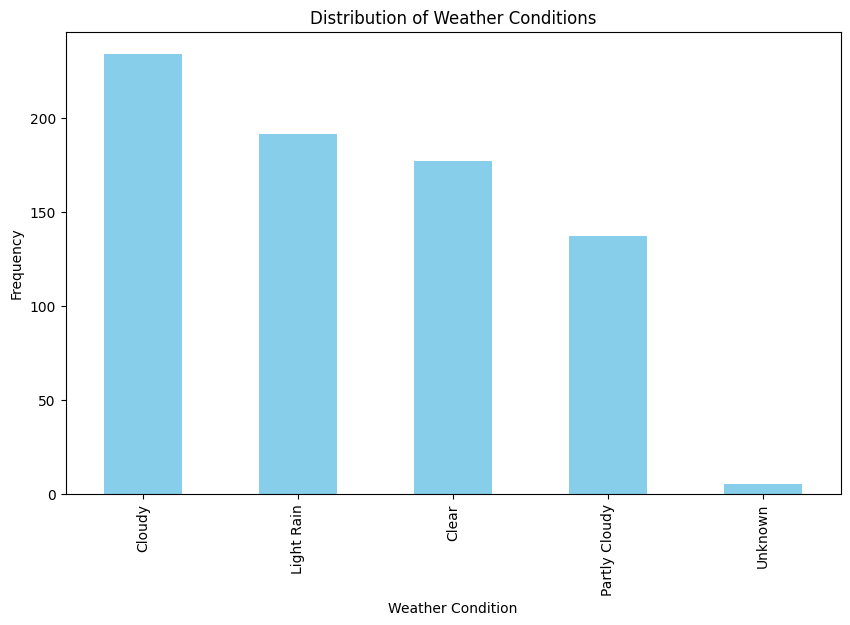

In [10]:
df['WeatherCondition'] = df.apply(classify_weather, axis=1)

plt.figure(figsize=(10, 6))
df['WeatherCondition'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.show()

In [11]:
df[df['WeatherCondition'] == 'Unknown']

,DateTime,AirPressure,AirTemperature,RelativeHumidity,WindSpeed,WindDirection,Precipitation,SunshineDuration,WeatherCondition
576,2024-10-20 01:00:00+08:00,1014.2,24.3,90,2.4,"東南東,ESE",0.100000,0.0,Unknown
580,2024-10-20 05:00:00+08:00,1014.4,24.5,90,2.4,"東南,SE",0.045455,0.0,Unknown
581,2024-10-20 06:00:00+08:00,1014.7,24.9,86,4.4,"東,E",0.090909,0.0,Unknown
664,2024-10-23 17:00:00+08:00,1010.7,22.1,83,3.6,"東,E",0.090909,0.0,Unknown
665,2024-10-23 18:00:00+08:00,1011.2,21.7,85,3.5,"東,E",0.045455,0.0,Unknown


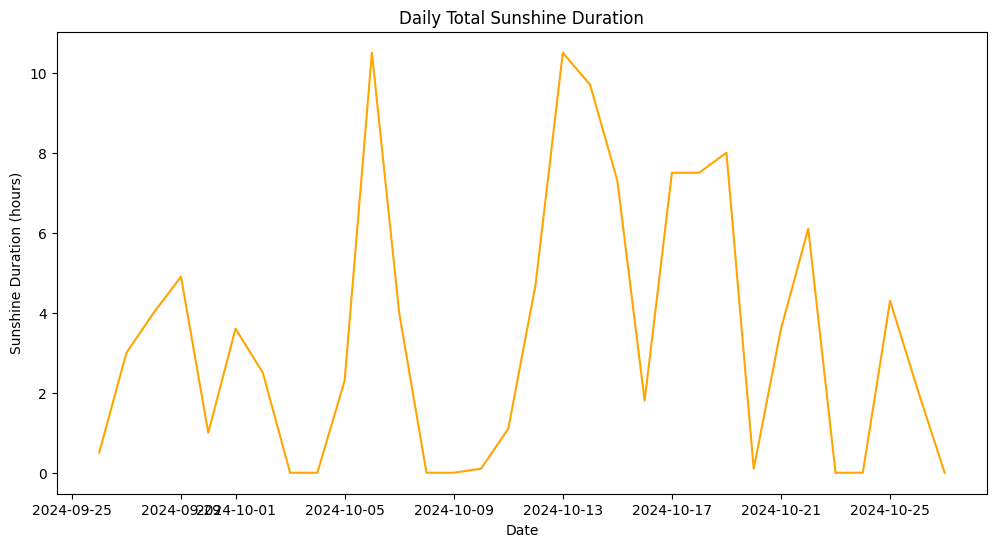

In [12]:
# 每日總日照時數趨勢圖
# 新增日期欄位並計算每日總日照時數
df['Date'] = df['DateTime'].dt.date
daily_sunshine = df.groupby('Date')['SunshineDuration'].sum()

plt.figure(figsize=(12, 6))
daily_sunshine.plot(kind='line', color='orange')
plt.title('Daily Total Sunshine Duration')
plt.xlabel('Date')
plt.ylabel('Sunshine Duration (hours)')
plt.show()

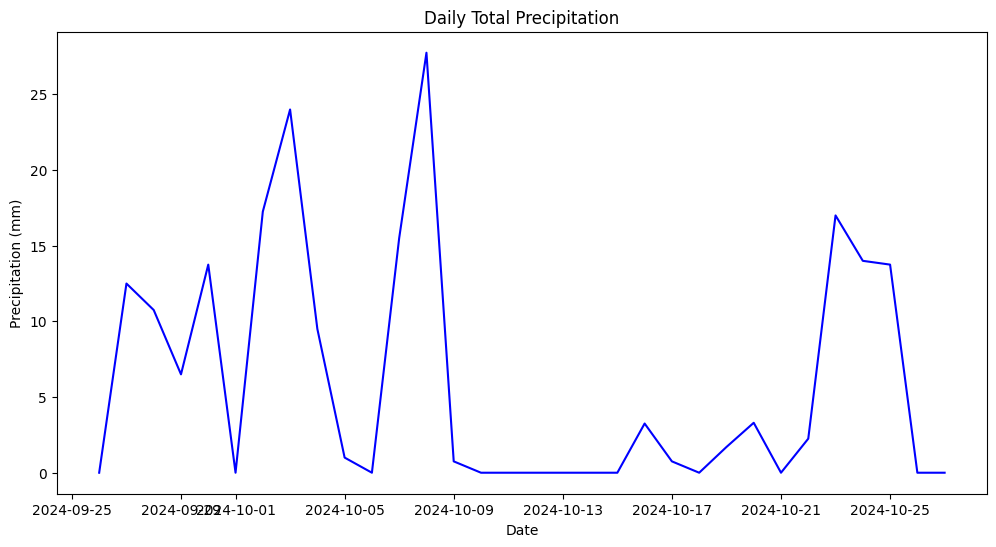

In [13]:
# 計算每日總降水量
daily_precipitation = df.groupby('Date')['Precipitation'].sum()

plt.figure(figsize=(12, 6))
daily_precipitation.plot(kind='line', color='blue')
plt.title('Daily Total Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.show()

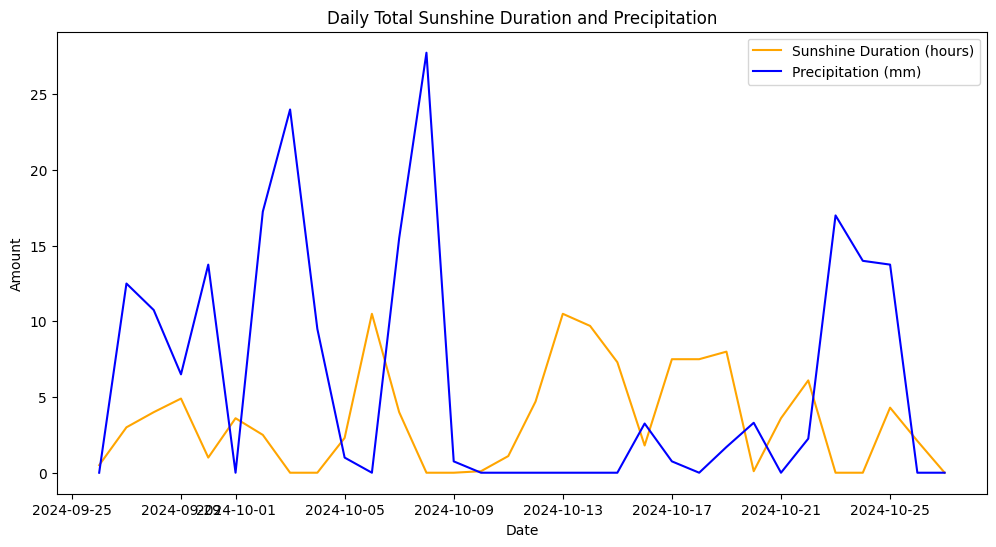

In [16]:
# 繪製在同一張圖上
plt.figure(figsize=(12, 6))
plt.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
plt.plot(daily_precipitation, label='Precipitation (mm)', color='blue')
plt.title('Daily Total Sunshine Duration and Precipitation')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


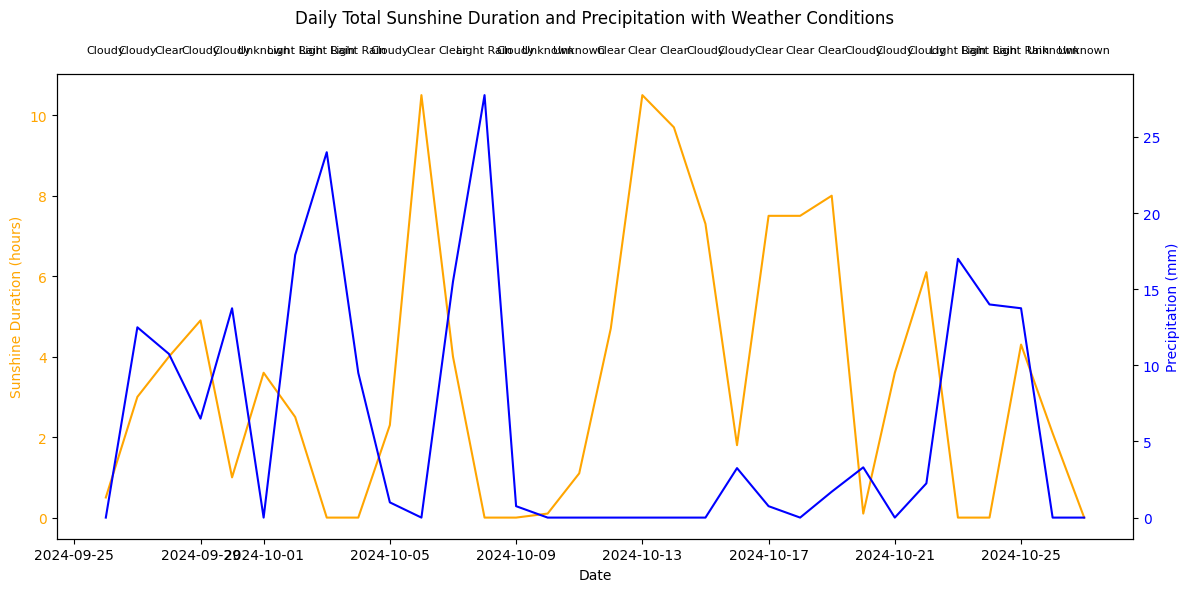

In [23]:
# 計算每日的主要天氣狀況
daily_weather = df.groupby('Date')['WeatherCondition'].agg(lambda x: x.mode()[0])

# 繪製圖表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 使用左側 y 軸顯示日照時數
ax1.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunshine Duration (hours)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# 創建右側 y 軸顯示降水量
ax2 = ax1.twinx()
ax2.plot(daily_precipitation, label='Precipitation (mm)', color='blue')
ax2.set_ylabel('Precipitation (mm)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 在圖表的上方標示每日的主要天氣狀況，橫向顯示
for date, weather in daily_weather.items():
    ax1.text(date, daily_sunshine.max() + 1, weather, fontsize=8, ha='center', va='bottom', rotation=0)

# 添加圖例和標題
fig.suptitle('Daily Total Sunshine Duration and Precipitation with Weather Conditions')
fig.tight_layout()
plt.show()


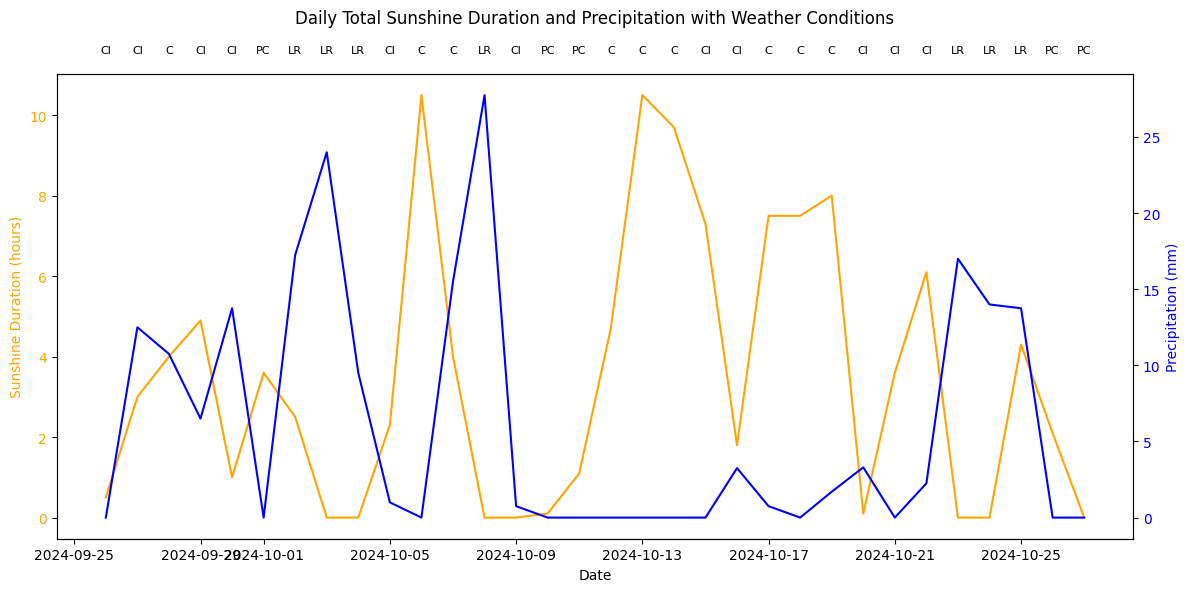

In [14]:
# 計算每日的主要天氣狀況並轉換為代號
weather_code = {
    'Clear': 'C',
    'Cloudy': 'Cl',
    'Partly Cloudy': 'PC',
    'Light Rain': 'LR',
    'Heavy Rain': 'HR',
    'Unknown': 'Unk'
}
daily_weather = df.groupby('Date')['WeatherCondition'].agg(lambda x: x.mode()[0]).map(weather_code)

# 繪製圖表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 使用左側 y 軸顯示日照時數
ax1.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunshine Duration (hours)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# 創建右側 y 軸顯示降水量
ax2 = ax1.twinx()
ax2.plot(daily_precipitation, label='Precipitation (mm)', color='blue')
ax2.set_ylabel('Precipitation (mm)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 在圖表的上方標示每日的主要天氣狀況代號
for date, weather in daily_weather.items():
    ax1.text(date, daily_sunshine.max() + 1, weather, fontsize=8, ha='center', va='bottom', rotation=0)

# 添加圖例和標題
fig.suptitle('Daily Total Sunshine Duration and Precipitation with Weather Conditions')
fig.tight_layout()
plt.show()


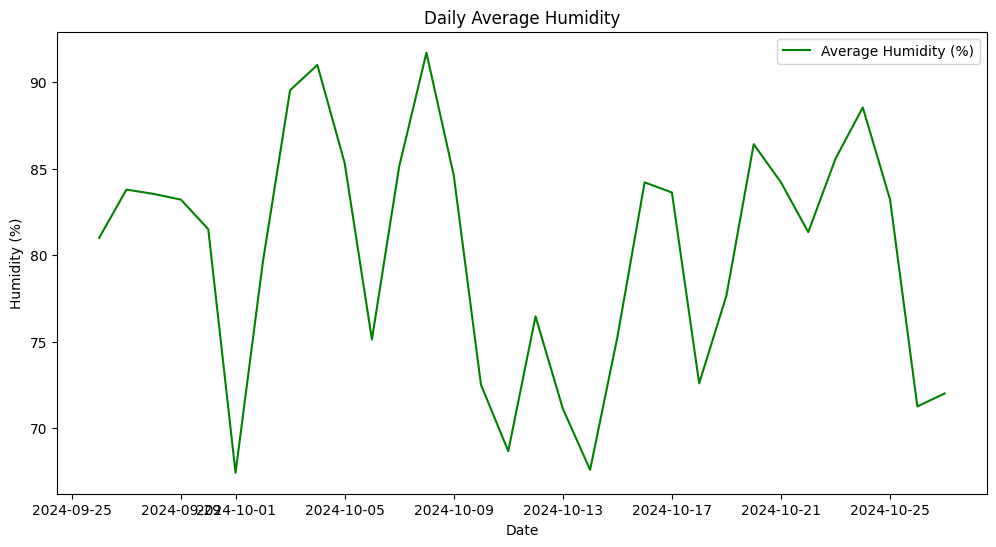

In [14]:
# 計算每日平均濕度
daily_avg_humidity = df.groupby('Date')['RelativeHumidity'].mean()

# 繪製每日平均濕度趨勢圖
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_humidity, label='Average Humidity (%)', color='green')
plt.title('Daily Average Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.show()


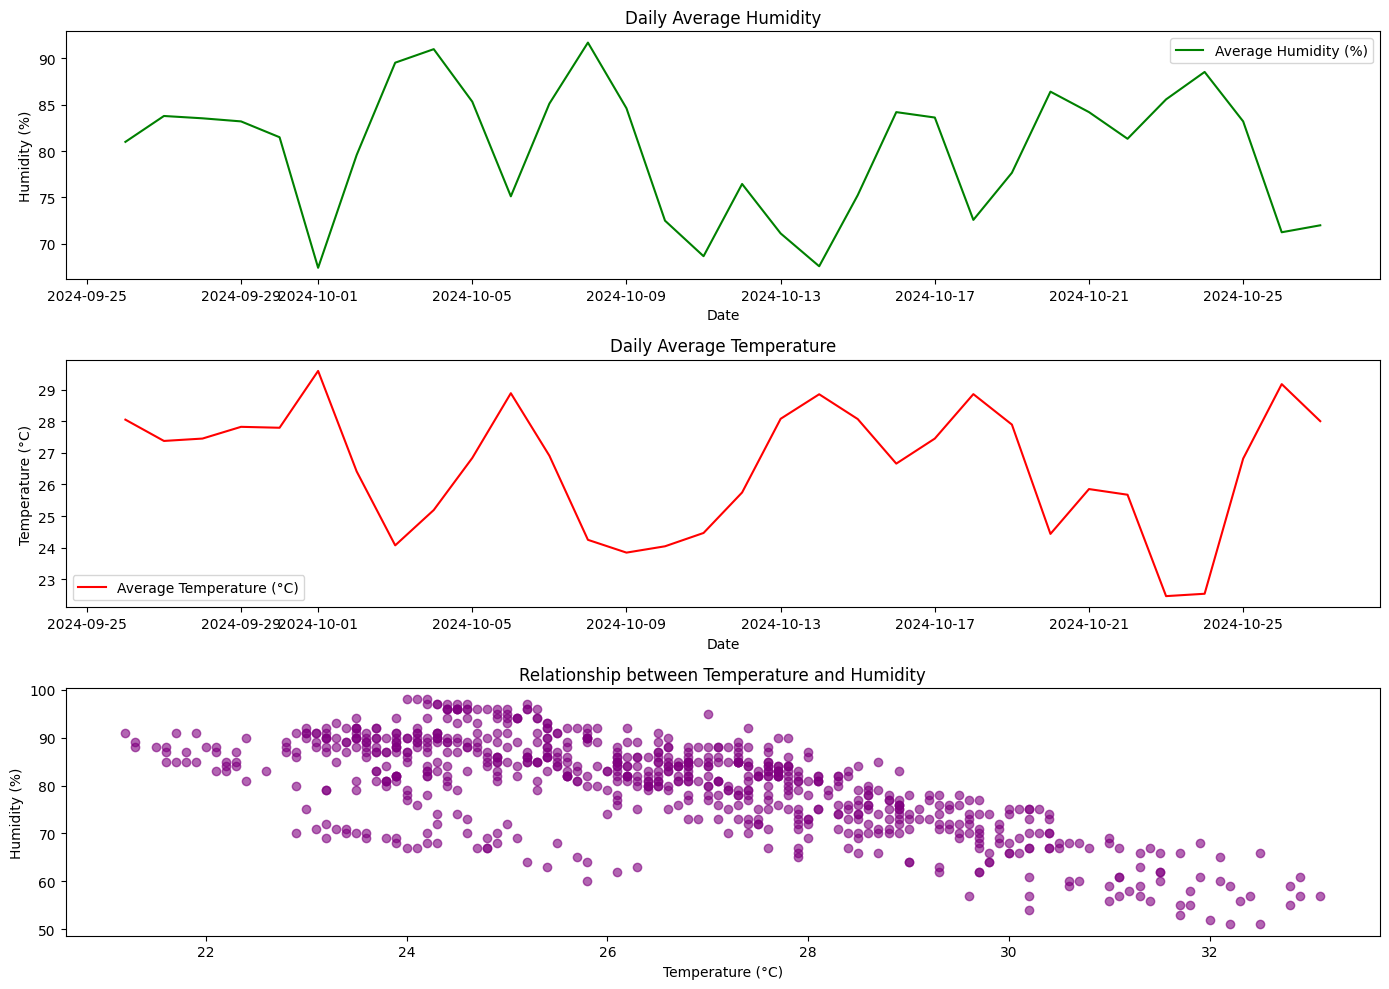

In [16]:
# 確保 'RelativeHumidity' 和 'AirTemperature' 欄位為數值格式
df['RelativeHumidity'] = pd.to_numeric(df['RelativeHumidity'], errors='coerce')
df['AirTemperature'] = pd.to_numeric(df['AirTemperature'], errors='coerce')

# 將 'DateTime' 欄位中的日期部分提取出來
df['Date'] = df['DateTime'].dt.date

# 計算每日平均濕度和每日平均溫度
daily_avg_humidity = df.groupby('Date')['RelativeHumidity'].mean()
daily_avg_temp = df.groupby('Date')['AirTemperature'].mean()

# 創建圖表
plt.figure(figsize=(14, 10))

# 子圖 1: 每日平均濕度趨勢圖
plt.subplot(3, 1, 1)
plt.plot(daily_avg_humidity, label='Average Humidity (%)', color='green')
plt.title('Daily Average Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()

# 子圖 2: 每日平均溫度趨勢圖
plt.subplot(3, 1, 2)
plt.plot(daily_avg_temp, label='Average Temperature (°C)', color='red')
plt.title('Daily Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# 子圖 3: 溫度與濕度的關係散佈圖
plt.subplot(3, 1, 3)
plt.scatter(df['AirTemperature'], df['RelativeHumidity'], alpha=0.6, color='purple')
plt.title('Relationship between Temperature and Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')

plt.tight_layout()  # 調整子圖之間的間距
plt.show()


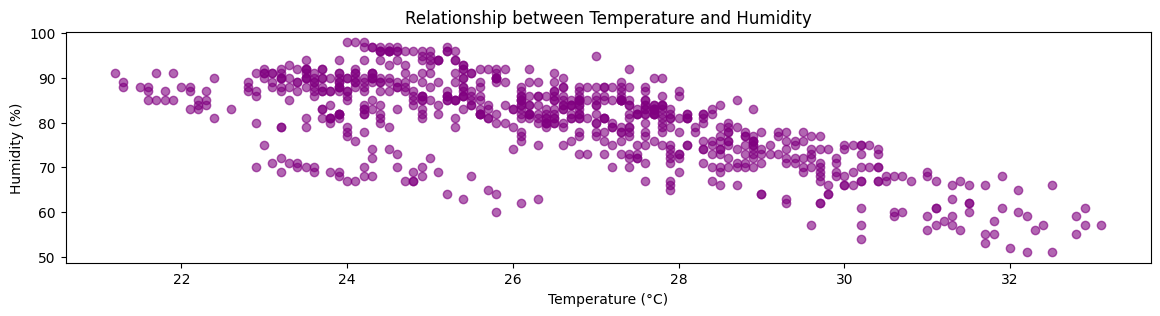

In [31]:
# 創建溫度與濕度的關係散佈圖
plt.figure(figsize=(14, 3))
plt.scatter(df['AirTemperature'], df['RelativeHumidity'], alpha=0.6, color='purple')
plt.title('Relationship between Temperature and Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.show()

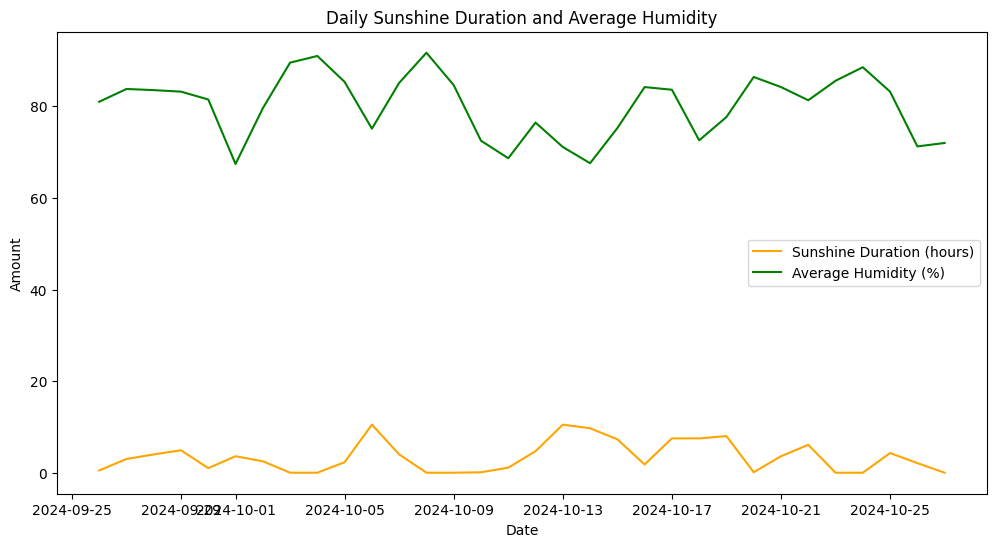

In [18]:
# 確保 'SunshineDuration' 和 'RelativeHumidity' 為數值格式，並計算每日數據
df['SunshineDuration'] = pd.to_numeric(df['SunshineDuration'], errors='coerce').fillna(0)
df['RelativeHumidity'] = pd.to_numeric(df['RelativeHumidity'], errors='coerce').fillna(0)

# 提取日期並計算每日總日照時數和平均濕度
df['Date'] = df['DateTime'].dt.date
daily_sunshine = df.groupby('Date')['SunshineDuration'].sum()
daily_avg_humidity = df.groupby('Date')['RelativeHumidity'].mean()

# 繪製圖表
plt.figure(figsize=(12, 6))

# 繪製每日總日照時數和每日平均濕度
plt.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
plt.plot(daily_avg_humidity, label='Average Humidity (%)', color='green')

# 添加圖例和標題
plt.title('Daily Sunshine Duration and Average Humidity')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()

plt.show()


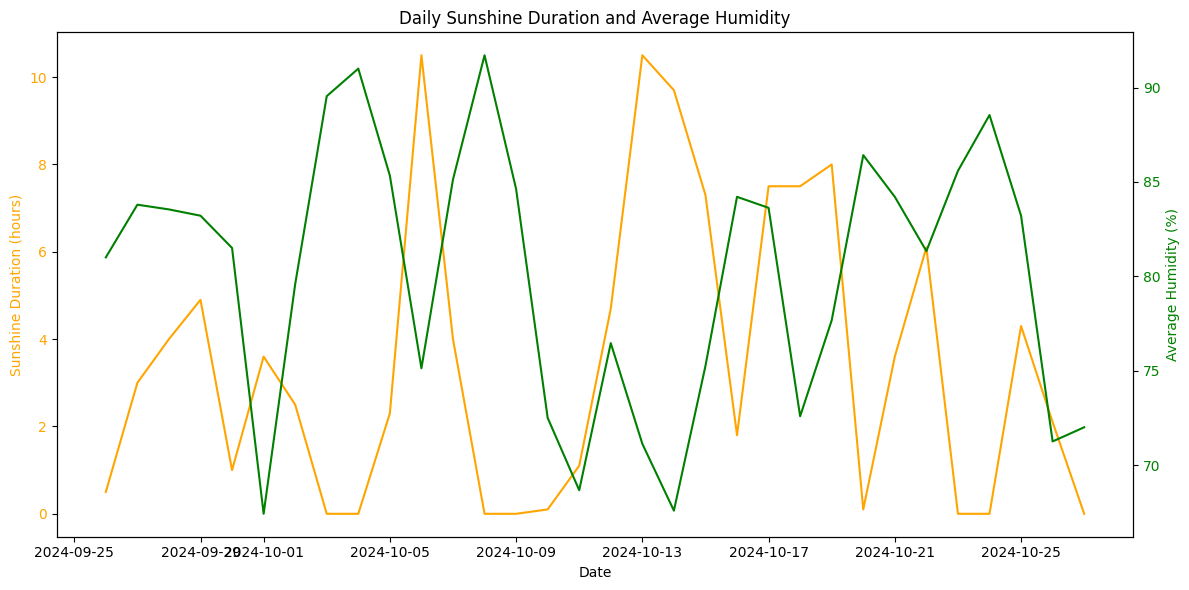

In [20]:
import matplotlib.pyplot as plt

# 確保 'SunshineDuration' 和 'RelativeHumidity' 為數值格式，並計算每日數據
df['SunshineDuration'] = pd.to_numeric(df['SunshineDuration'], errors='coerce').fillna(0)
df['RelativeHumidity'] = pd.to_numeric(df['RelativeHumidity'], errors='coerce').fillna(0)

# 提取日期並計算每日總日照時數和平均濕度
df['Date'] = df['DateTime'].dt.date
daily_sunshine = df.groupby('Date')['SunshineDuration'].sum()
daily_avg_humidity = df.groupby('Date')['RelativeHumidity'].mean()

# 繪製圖表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 繪製每日總日照時數（副軸）
ax1.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunshine Duration (hours)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# 創建第二個 y 軸來顯示濕度
ax2 = ax1.twinx()
ax2.plot(daily_avg_humidity, label='Average Humidity (%)', color='green')
ax2.set_ylabel('Average Humidity (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加標題和圖例
plt.title('Daily Sunshine Duration and Average Humidity')
fig.tight_layout()
plt.show()


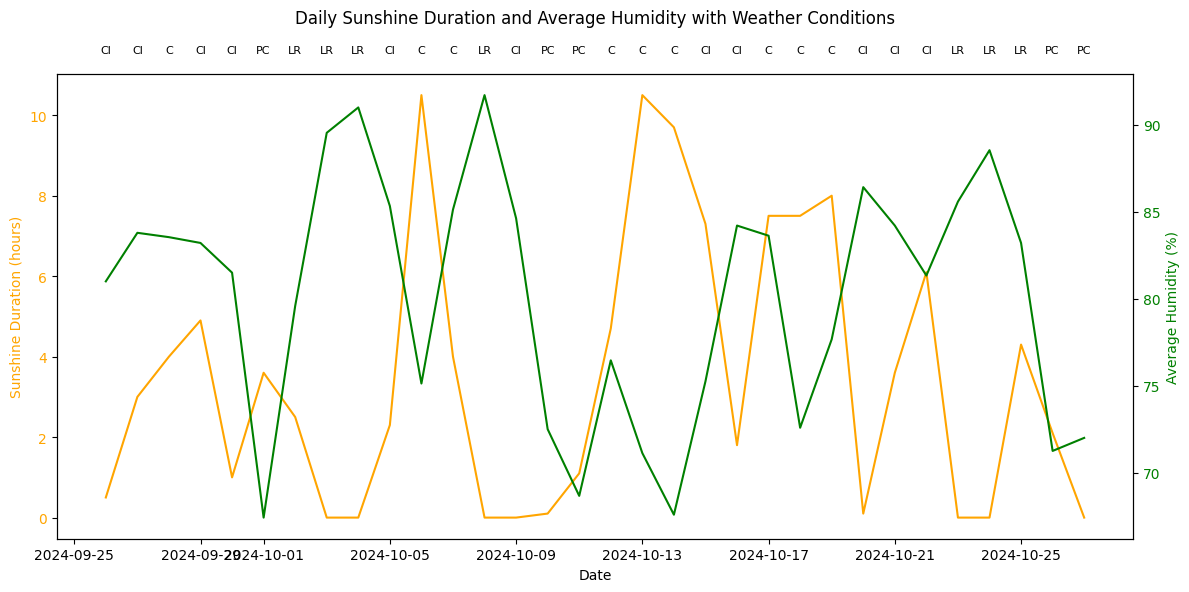

In [20]:
import matplotlib.pyplot as plt

# 確保 'SunshineDuration' 和 'RelativeHumidity' 為數值格式，並計算每日數據
df['SunshineDuration'] = pd.to_numeric(df['SunshineDuration'], errors='coerce').fillna(0)
df['RelativeHumidity'] = pd.to_numeric(df['RelativeHumidity'], errors='coerce').fillna(0)

# 提取日期並計算每日總日照時數和平均濕度
df['Date'] = df['DateTime'].dt.date
daily_sunshine = df.groupby('Date')['SunshineDuration'].sum()
daily_avg_humidity = df.groupby('Date')['RelativeHumidity'].mean()

# 計算每日的主要天氣狀況並轉換為代號
weather_code = {
    'Clear': 'C',
    'Cloudy': 'Cl',
    'Partly Cloudy': 'PC',
    'Light Rain': 'LR',
    'Heavy Rain': 'HR',
    'Unknown': 'Unk'
}
daily_weather = df.groupby('Date')['WeatherCondition'].agg(lambda x: x.mode()[0]).map(weather_code)

# 繪製圖表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 繪製每日總日照時數
ax1.plot(daily_sunshine, label='Sunshine Duration (hours)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunshine Duration (hours)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# 創建第二個 y 軸來顯示濕度
ax2 = ax1.twinx()
ax2.plot(daily_avg_humidity, label='Average Humidity (%)', color='green')
ax2.set_ylabel('Average Humidity (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 在圖表的上方標示每日的主要天氣狀況代號
for date, weather in daily_weather.items():
    ax1.text(date, daily_sunshine.max() + 1, weather, fontsize=8, ha='center', va='bottom', rotation=0)

# 添加標題和圖例
plt.suptitle('Daily Sunshine Duration and Average Humidity with Weather Conditions')
fig.tight_layout()
plt.show()
